In [1]:
# Ref: https://cdn.rawgit.com/mstrazar/mklaren/master/docs/quick_start.html
import mklaren
import numpy as np
np.set_printoptions(precision=5)

In [6]:
from datasets.delve import load_boston
data = load_boston()
X = data["data"]
y = data["target"]
print X.shape

tr = range(0, len(X), 2)
te = range(1, len(X), 2)
X_tr, X_te = X[tr], X[te]
y_tr, y_te = y[tr], y[te]

(506, 13)


In [9]:
from mklaren.kernel.kinterface import Kinterface
from mklaren.kernel.kernel import linear_kernel, poly_kernel, rbf_kernel
from mklaren.regression.ridge import RidgeLowRank

K_exp  = Kinterface(data=X_tr, kernel=rbf_kernel,  kernel_args={"sigma": 30}) # RBF kernel 
K_poly = Kinterface(data=X_tr, kernel=poly_kernel, kernel_args={"p": 3})      # polynomial kernel with degree=3
K_lin  = Kinterface(data=X_tr, kernel=linear_kernel)                          # linear kernel

model = RidgeLowRank(method="nystrom", rank=5, lbd=1)
model.fit([K_exp, K_lin, K_poly], y_tr)
yp = model.predict([X_te, X_te, X_te])                     # The features passed to each kernel
rmse = np.var(y_tr-yp)**0.5
print "Test RMSE:", rmse

Test RMSE: 8.24654690751


In [10]:
from mklaren.mkl.mklaren import Mklaren

K_exp  = Kinterface(data=X_tr, kernel=rbf_kernel,  kernel_args={"sigma": 30})  # RBF kernel 
K_poly = Kinterface(data=X_tr, kernel=poly_kernel, kernel_args={"p": 3})      # polynomial kernel with degree=3
K_lin  = Kinterface(data=X_tr, kernel=linear_kernel)  
model = Mklaren(rank=15, lbd=1, delta=30)
model.fit([K_exp, K_lin, K_poly], y_tr)
yp = model.predict([X_te, X_te, X_te])
print "Test RMSE:", np.var(y_te-yp)**0.5



Test RMSE: 6.85100919279


In [4]:
# Load save experimental setup
import pickle
from sklearn import preprocessing
# from mklaren.kernel.kinterface import Kinterface
# from mklaren.kernel.kernel import linear_kernel, poly_kernel, rbf_kernel
# from mklaren.regression.ridge import RidgeLowRank
# from mklaren.mkl.mklaren import Mklaren
# from mklaren.mkl.align import Align
# from mklaren.mkl.alignf import Alignf
from sklearn.metrics import mean_squared_error as mse 
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import grid_search
from sklearn.kernel_ridge import KernelRidge
%matplotlib inline
# plt.style.use('ggplot')

/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

In [15]:
cohorts = ['ADNI1','ADNI2','ADNI1and2']
exp_name = 'Exp6'
Clinical_Scales = ['ADAS13','MMSE']

baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/'
CV_model_dir = baseline_dir + 'output/'
df_perf_dict = {}
idx = 1
print 'exp_name:{}'.format(exp_name)
MC_runs = 10

for cohort in cohorts:
    for Clinical_Scale in Clinical_Scales:
        print 'cohort: {}, Clinical Scale: {}'.format(cohort,Clinical_Scale)
        for mc in np.arange(1,MC_runs+1,1):   
            print 'MC: {}'.format(mc)
            #Load data
            exp_setup_path = baseline_dir + 'CV_{}_{}_{}_MC_{}.pkl'.format(exp_name,cohort,Clinical_Scale,mc)
            exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
            X_raw = exp_setup['X']
            X = preprocessing.scale(X_raw)
            y = exp_setup['y']        
            kf = exp_setup['kf']
            fid = 1
            for train, valid in kf:    
                #select train and test sets
                X_tr_HC = X[train][:,:2]
                X_tr_CT = X[train][:,2:]
                X_te_HC = X[valid][:,:2]
                X_te_CT = X[valid][:,2:]
                y_tr = y[train]
                y_te = y[valid]
                
                for delta in [10,20,30]:
                    for sigma in [1,5,10,25]:
                        for rank in [10,50,80]:
                            #multi-kernel learning
                            K_lin_HC  = Kinterface(data=X_tr_HC, kernel=linear_kernel) 
                            K_rbf_HC  = Kinterface(data=X_tr_HC, kernel=rbf_kernel, kernel_args={"sigma": sigma}) 
                            K_lin_CT  = Kinterface(data=X_tr_CT, kernel=linear_kernel)  
                            K_rbf_CT  = Kinterface(data=X_tr_CT, kernel=rbf_kernel, kernel_args={"sigma": sigma})  
                            model = Mklaren(rank=rank, lbd=1, delta=delta)                  
                            #model = Alignf(typ="linear")
                            try:
                                model.fit([K_lin_HC, K_lin_CT, K_rbf_HC, K_rbf_CT], y_tr)

            #                     mu = model.mu
            #                     combined_kernel = lambda x, y: \
            #                         mu[0] * K_lin_HC(x, y) + mu[1] * K_lin_CT(x, y) + mu[2] * K_rbf_HC(x, y)+ mu[3] * K_rbf_CT(x, y)                                      
            #                     krr = KernelRidge(kernel=combined_kernel, alpha=10.0)
            #                     clf = grid_search.GridSearchCV(krr, hyper_params,cv=3,verbose=0)
            #                     clf.fit(X[train], y[train])
            #                     krr.fit(X[train], y[train])

                                #predict
                                y_pred = model.predict([X_te_HC,X_te_CT,X_te_HC,X_te_CT])
                                df_perf_dict[idx] = {'cohort':cohort, 'Clinical_Scale':Clinical_Scale, 'MC':mc,'KF':fid, 
                                                     'y_act':y_te,'y_pred':y_pred, 'sigma':sigma, 'delta':delta, 'rank':rank}     

                            except np.linalg.linalg.LinAlgError as err:
                                if 'Singular matrix' in err.message:
                                    # your error handling block
                                    print 'Singular matrix exception for mc: {}, kf {}'.format(mc,fid)
                                else:
                                    raise


                            idx+=1
                    
                fid+=1
        #Save df style dictionaly for seaborn plots
        df_perf_dict_path = CV_model_dir + 'df_MKL_perf_dict_{}_{}_{}.pkl'.format(exp_name,cohort,Clinical_Scale)
        pickleIt(df_perf_dict,df_perf_dict_path)
        print 'saving results at: {}'.format(df_perf_dict_path)
        


exp_name:Exp6
cohort: ADNI1, Clinical Scale: ADAS13
MC: 1
Matrix is singular and may not have a square root.
Matrix is singular and may not have a square root.
saving results at: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/df_MKL_perf_dict_Exp6_ADNI1_ADAS13.pkl
MC: 2


/mnt/tigrlab/projects/nikhil/ADNI_prediction/code/conda_envs/mkl_svm/lib/python2.7/site-packages/ipykernel/__main__.py:61: DeprecationWarning: BaseException.message has been deprecated as of Python 2.6


Singular matrix exception for mc: 2, kf 3
Singular matrix exception for mc: 2, kf 3
saving results at: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/df_MKL_perf_dict_Exp6_ADNI1_ADAS13.pkl
MC: 3
saving results at: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/df_MKL_perf_dict_Exp6_ADNI1_ADAS13.pkl
MC: 4
Singular matrix exception for mc: 4, kf 9
Singular matrix exception for mc: 4, kf 9
Singular matrix exception for mc: 4, kf 9
Singular matrix exception for mc: 4, kf 9
Singular matrix exception for mc: 4, kf 9
Singular matrix exception for mc: 4, kf 9
saving results at: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/df_MKL_perf_dict_Exp6_ADNI1_ADAS13.pkl
MC: 5
Singular matrix exception for mc: 5, kf 4
Singular matrix exception for mc: 5, kf 6
saving results at: /projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/df_MKL_perf_dict_Exp6_ADNI1_ADAS13.pkl
MC: 6
saving results at: /

In [74]:
exp_name = 'Exp6'
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/'

cohorts = ['ADNI1','ADNI2','ADNI1and2']
Clinical_Scales = ['ADAS13','MMSE']

df_concat = pd.DataFrame(columns=['cohort','Clinical_Scale','MC','KF','y_act','y_pred','r','rmse'])
for cohort in cohorts:
    for cs in Clinical_Scales:
        print cohort, cs
        MKL_perf_path = baseline_dir + 'df_MKL_perf_dict_{}_{}_{}.pkl'.format(exp_name, cohort, cs)
        df_perf_dict = pickle.load( open(MKL_perf_path, "rb" ) )
        df_raw = pd.DataFrame.from_dict(df_perf_dict,orient='index')
        df = df_raw[(df_raw['rank']==80)&(df_raw['delta']==30)&(df_raw['sigma']==10)
                     &(df_raw['cohort']==cohort)&(df_raw['Clinical_Scale']==cs)]
        
        CV_y_act = df[df.Clinical_Scale == cs]['y_act']
        CV_y_pred = df[df.Clinical_Scale == cs]['y_pred']
        idx_list = df[df.Clinical_Scale == cs].index
        for idx in idx_list:
            y_act = CV_y_act[idx]
            y_pred = CV_y_pred[idx]                
            rmse = np.sqrt(mse(y_act,y_pred))
            r = stats.pearsonr(y_act,y_pred)[0]
            df.set_value(idx,'r', r)
            df.set_value(idx,'rmse', rmse)
        
        df_concat = df_concat.append(df,ignore_index=True)



for cohort in cohorts:
    for cs in Clinical_Scales:
        r = df_concat[(df_concat.Clinical_Scale==cs)&(df_concat.cohort == cohort)]['r'].values
        rmse = df_concat[(df_concat.Clinical_Scale==cs)&(df_concat.cohort == cohort)]['rmse'].values
        print cohort, cs
        print len(r)
        print np.mean(r), np.std(r), np.mean(rmse), np.std(rmse) 
        

ADNI1 ADAS13
ADNI1 MMSE
ADNI2 ADAS13
ADNI2 MMSE
ADNI1and2 ADAS13
ADNI1and2 MMSE
ADNI1 ADAS13
98
0.55136879508 0.0789862333969 7.52358190405 0.745329001355
ADNI1 MMSE
100
0.504053014659 0.0740456773754 2.26708660438 0.168328189477
ADNI2 ADAS13
98
0.603437117572 0.077698158622 7.91855360741 0.639973751369
ADNI2 MMSE
99
0.508918138112 0.0778541292312 2.32878591628 0.179548738558
ADNI1and2 ADAS13
94
0.568300358751 0.0589383912923 7.88659746484 0.460270581402
ADNI1and2 MMSE
98
0.504543599589 0.068239637309 2.31560022607 0.126925920785


/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/projects/nikhil/ADNI_prediction/code/conda_envs/adni-conda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


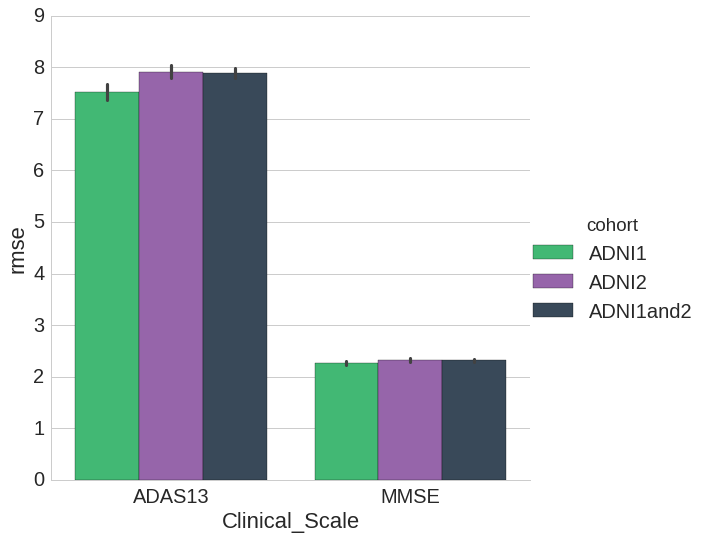

In [88]:
sns.set(font_scale=2)
flatui = ["#2ecc71", "#9b59b6","#34495e", ]
palette = sns.color_palette(flatui)
with sns.axes_style("whitegrid"):
    g = sns.factorplot(x="Clinical_Scale", y="rmse", hue='cohort', sharey=True, kind="bar", size=8, palette=palette,
                  data=df_concat[(df_concat['rank']==80)&(df_concat['delta']==30)&(df_concat['sigma']==10)])

1187


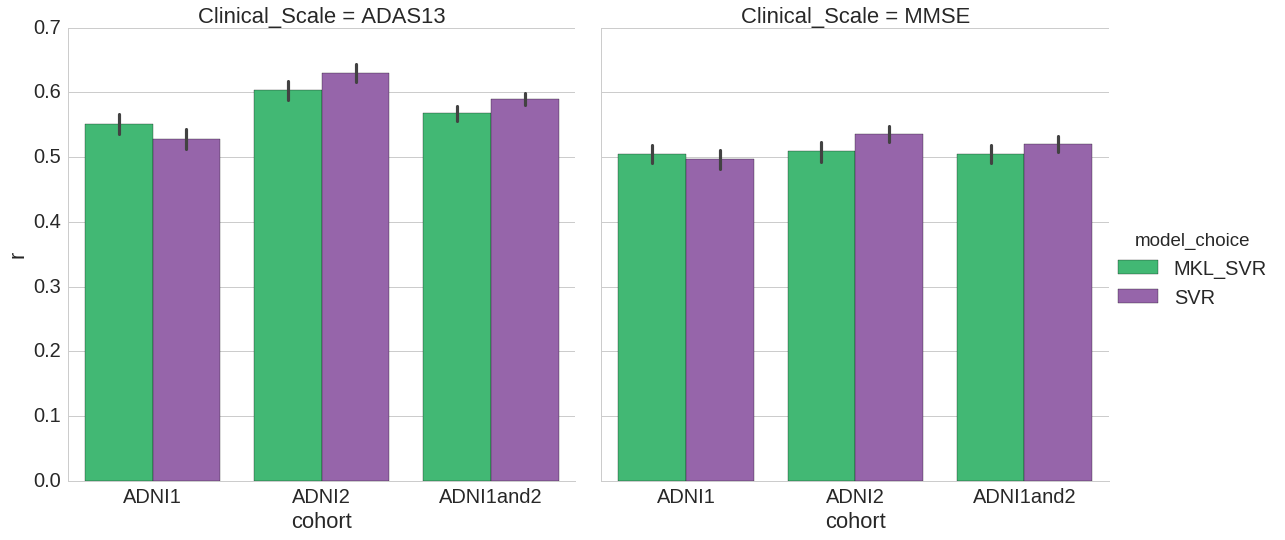

In [92]:
cols = ['cohort','Clinical_Scale','model_choice','MC','KF','r','rmse']
df_concat_svm_mklsvm = pd.DataFrame(columns=cols)
df_concat_svm_mklsvm = df_concat_svm_mklsvm.append(df_concat_mklsvm[cols])
df_concat_svm_mklsvm = df_concat_svm_mklsvm.append(df_concat_svm[cols])
print len(df_concat_svm_mklsvm)

with sns.axes_style("whitegrid"):
    g = sns.factorplot(x="cohort", y="r", hue='model_choice', col='Clinical_Scale', sharey=True, kind="bar", 
                       size=8, palette=palette, data=df_concat_svm_mklsvm)

In [84]:
df_concat_mklsvm = df_concat[(df_concat['rank']==80)&(df_concat['delta']==30)&(df_concat['sigma']==10)]
df_concat_mklsvm['model_choice']=np.tile('{}'.format('MKL_SVR'),len(df_concat_mklsvm))
print len(df_concat_mklsvm)

587


In [90]:
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/exp_data/baseline_MC/output/'
cohorts = ['ADNI1','ADNI2','ADNI1and2']
clinical_scales = ['ADAS13','MMSE']
p=0
for cohort in cohorts:
    for clinical_scale in clinical_scales:        
        print cohort, clinical_scale
        df_perf_dict = pickle.load( open(baseline_dir + 'df_perf_dict_Exp6_{}_{}.pkl'.format(cohort,clinical_scale), 'rb') )
        df = pd.DataFrame.from_dict(df_perf_dict,orient='index')
        df['r']= (zip(*df['CV_r'].values)[0])
        df['rmse']= df['CV_RMSE'].values
        df['CV_r_pval']= (zip(*df['CV_r'].values)[1])
        df['cohort']=np.tile('{}'.format(cohort),len(df_perf_dict))                
        df['Clinical_Scale']=np.tile('{}'.format(clinical_scale),len(df_perf_dict))                
                
        if p==0:
            df_concat_svm = df[(df.model_choice=='SVR')&(df.modality=='HC_CT')]
        else:        
            df_concat_svm = df_concat_svm.append(df[(df.model_choice=='SVR')&(df.modality=='HC_CT')])
            
        p+=1

ADNI1 ADAS13
ADNI1 MMSE
ADNI2 ADAS13
ADNI2 MMSE
ADNI1and2 ADAS13
ADNI1and2 MMSE


In [81]:
#Significance tests for comparing model perf
import itertools
model_choices = ['SVR']
modalities = ['HC_CT']
cohorts = ['ADNI1','ADNI2','ADNI1and2']
clinical_scales = ['ADAS13','MMSE']
use_atanh = True
idx=0
print 'use_atanh: {}'.format(use_atanh)
for cohort in cohorts: 
    for Clinical_Scale in clinical_scales:
            x = df_concat[(df_concat_mklsvm.cohort == cohort) & (df_concat_mklsvm.Clinical_Scale == Clinical_Scale)]['r'].values
            y = df_concat_svm[(df_concat_svm.cohort == cohort) & (df_concat_svm.Clinical_Scale == Clinical_Scale) &
                         (df_concat_svm.modality == 'HC_CT')]['r'].values
            
            if len(x) == len(y):
                sign = computeSignficance(x,y,use_atanh)
            else:
                l = np.minimum(len(x),len(y))
                sign = computeSignficance(x[:l],y[:l],use_atanh)
            print cohort, Clinical_Scale, modality, len(x), len(y), np.mean(x), np.mean(y), sign
    print ''

use_atanh: True
ADNI1 ADAS13 HC_CT 98 100 0.55136879508 0.528549969481 ***
ADNI1 MMSE HC_CT 100 100 0.504053014659 0.496406875407 *

ADNI2 ADAS13 HC_CT 98 100 0.603437117572 0.630327479215 *
ADNI2 MMSE HC_CT 99 100 0.508918138112 0.535222028794 ***

ADNI1and2 ADAS13 HC_CT 94 100 0.568300358751 0.590328478642 **
ADNI1and2 MMSE HC_CT 98 100 0.504543599589 0.520405655052 *



In [46]:
#Compute signficance of performance differences. If using correlations then use arctanh before the t-test
def computeSignficance(x,y,use_atanh):
    if use_atanh:
        #print 'Transforming correlation values using atan function'
        x = np.arctanh(x)
        y = np.arctanh(y)
        
    #compute t-tests
    t_val, p_val = stats.ttest_rel(x,y)    
    if p_val < 0.001:
        out = '***'
    elif p_val < 0.01:
        out = '**'
    elif p_val < 0.05:
        out = '*'
    else:
        out = ''
        
    return out

In [89]:
df_concat_svm

,CV_RMSE,model_choice,KF,MC,CV_R2,CV_r,CV_MSE,modality,r,CV_r_pval,cohort,Clinical_Scale
71,7.771576,SVR,1,1,0.199871,"(0.485075789139, 2.76170005459e-05)",60.397400,HC_CT,0.485076,2.761700e-05,ADNI1,ADAS13
72,7.821766,SVR,2,1,0.186137,"(0.461613451407, 7.42591812133e-05)",61.180024,HC_CT,0.461613,7.425918e-05,ADNI1,ADAS13
73,6.897193,SVR,3,1,0.386920,"(0.63312014879, 6.89981989975e-09)",47.571268,HC_CT,0.633120,6.899820e-09,ADNI1,ADAS13
74,8.550070,SVR,4,1,0.237390,"(0.498725206751, 1.50119063173e-05)",73.103703,HC_CT,0.498725,1.501191e-05,ADNI1,ADAS13
75,6.776125,SVR,5,1,0.295815,"(0.557586882651, 7.83931817789e-07)",45.915874,HC_CT,0.557587,7.839318e-07,ADNI1,ADAS13
76,6.193643,SVR,6,1,0.459198,"(0.682548108868, 1.99990277872e-10)",38.361213,HC_CT,0.682548,1.999903e-10,ADNI1,ADAS13
77,8.352873,SVR,7,1,0.199887,"(0.448611282238, 0.000158232530262)",69.770489,HC_CT,0.448611,1.582325e-04,ADNI1,ADAS13
78,6.856651,SVR,8,1,0.308970,"(0.635977376661, 9.58250269261e-09)",47.013659,HC_CT,0.635977,9.582503e-09,ADNI1,ADAS13
79,7.377707,SVR,9,1,0.100080,"(0.394170380078, 0.00115868882699)",54.430554,HC_CT,0.394170,1.158689e-03,ADNI1,ADAS13
80,9.959824,SVR,10,1,0.175165,"(0.423843495024, 0.000434414921037)",99.198101,HC_CT,0.423843,4.344149e-04,ADNI1,ADAS13
